## Курсовой проект по курсу "Библиотеки Python для Data Science: продолжение "

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = 'course_project/course_project_train.csv' 
TEST_DATASET_PATH = 'course_project/course_project_test.csv'

### Загрузка данных

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

### Обзор данных

#### Количественные переменные

In [6]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Категориальные переменные

In [7]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

#### Целевая переменная

In [8]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Обработка пропусков, нулевых значений и значений некоторых категориальных признаков

In [9]:
train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [10]:
train['Annual Income'].isnull() 

0       False
1       False
2       False
3       False
4       False
        ...  
7495    False
7496    False
7497    False
7498     True
7499     True
Name: Annual Income, Length: 7500, dtype: bool

In [11]:
train['Annual Income'].mean()

1366391.7201749957

In [12]:
train.loc[train['Annual Income'].isnull(), 'Annual Income'] = train['Annual Income'].mean()



In [13]:
train['Months since last delinquent'].isna().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

In [14]:
train.loc[train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = train['Months since last delinquent'].mean()

In [15]:
train['Credit Score'].isnull().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

In [16]:
train.loc[train['Credit Score'].isnull(), 'Credit Score'] = train['Credit Score'].mean()

In [17]:

train['Years in current job'].isna().value_counts()

False    7129
True      371
Name: Years in current job, dtype: int64

In [18]:
train['Years in current job'].mode()

0    10+ years
dtype: object

In [19]:
train.loc[:,'Years in current job'].fillna(train['Years in current job'].mode()[0],inplace=True)


In [20]:
train.loc[train['Years in current job'] == 'NaN', 'Years in current job'] = train['Years in current job'].mode()[0]
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [21]:
train['Years in current job'].isnull().value_counts()

False    7500
Name: Years in current job, dtype: int64

In [22]:
train['Years in current job']

0       10+ years
1       10+ years
2         8 years
3         6 years
4         8 years
          ...    
7495     < 1 year
7496       1 year
7497      6 years
7498    10+ years
7499      4 years
Name: Years in current job, Length: 7500, dtype: object

In [23]:
replace_nums = {"< 1 year": 0, "1 year": 1, "2 years": 2, "3 years": 3, "4 years": 4, "5 years": 5, "6 years":6,"7 years":7,"8 years":8, "9 years":9, "10+ years":10}
train['Years in current job'] = train['Years in current job'].replace(replace_nums)

In [24]:
train['Bankruptcies'].isnull().value_counts()

False    7486
True       14
Name: Bankruptcies, dtype: int64

In [25]:
train.loc[train['Bankruptcies'].isnull(), 'Bankruptcies'] = train['Bankruptcies'].mean()

In [26]:
train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Построение новых признаков

In [27]:
train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [28]:
train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [29]:
train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [30]:
train['Term'] = train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
train['Term']

0       0
1       1
2       0
3       0
4       0
       ..
7495    0
7496    1
7497    0
7498    0
7499    0
Name: Term, Length: 7500, dtype: int32

In [31]:
df = pd.get_dummies(train)

In [32]:
df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding'],
      dtype='object')

In [33]:
df.shape

(7500, 34)

### Выделение целевой переменной и групп признаков

In [34]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()


In [35]:
NEW_FEATURE_NAMES = ['Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding']

In [36]:
NUM_FEATURE_NAMES = ['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',                   
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score'
 ]

In [37]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Анализ целевой переменной

In [38]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

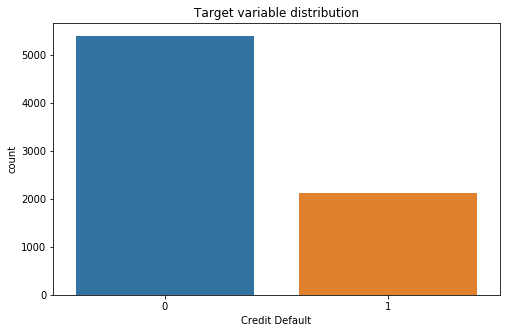

In [39]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

#### Корреляция с базовыми признаками

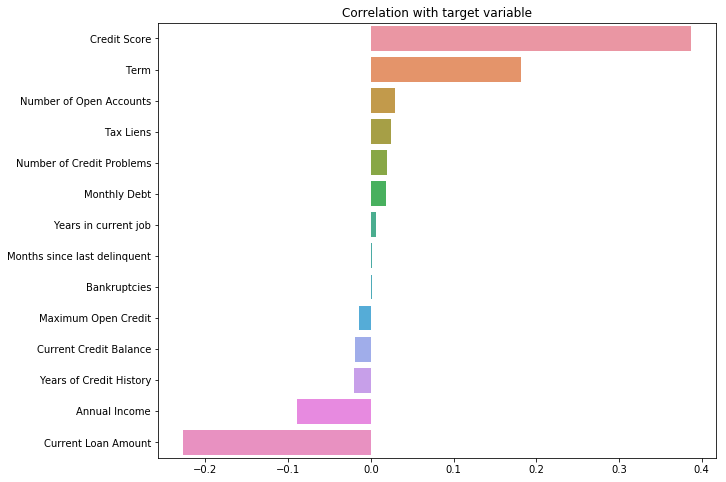

In [40]:
corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[: -1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Оценка признака "Credit Score" в разрезе целевой переменной

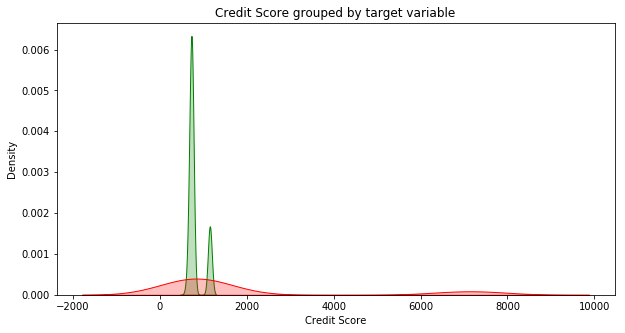

In [41]:
cs_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
cs_s = cs_with_target_s['Credit Score']
cs_0 = cs_s[cs_with_target_s[TARGET_NAME] == 0]
cs_1 = cs_s[cs_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cs_0, shade=True, label='No default', color='g')
sns.kdeplot(cs_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [42]:
shapiro(cs_s)

ShapiroResult(statistic=0.308358371257782, pvalue=0.0)

Нулевая гипотеза о нормальности отвергается

#### Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

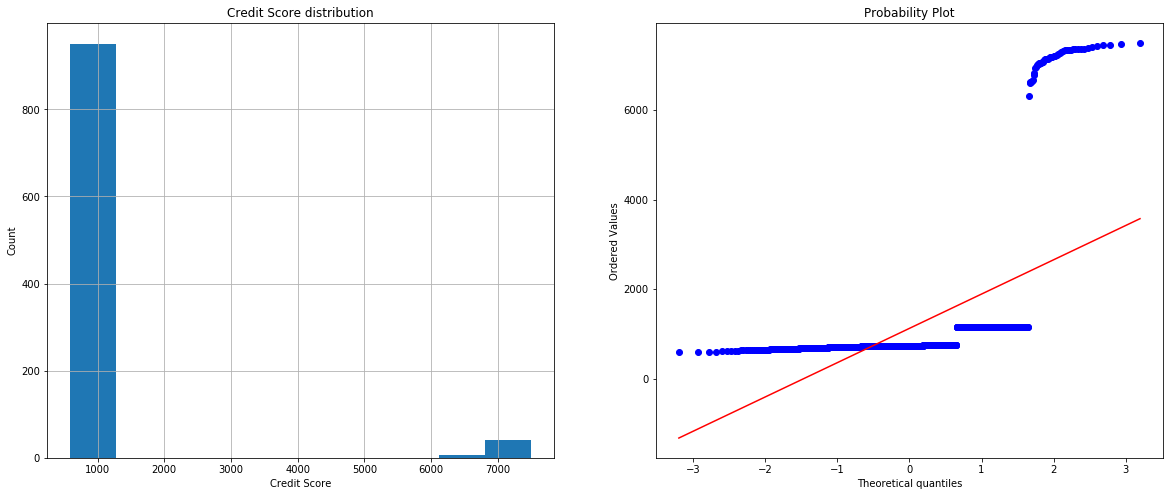

In [43]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
cs_s.hist()

plt.subplot(122)
probplot(cs_s, dist='norm', plot=plt)

plt.show()

In [44]:
mannwhitneyu(cs_0, cs_1)

MannwhitneyuResult(statistic=86152.0, pvalue=0.0008895791809697459)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

#### Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

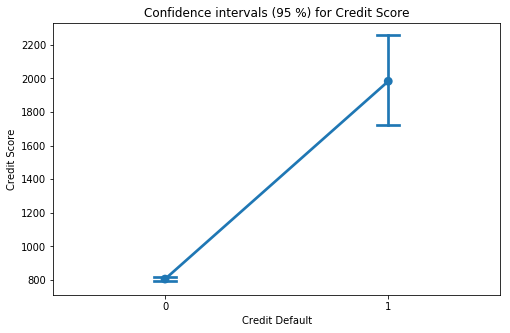

In [45]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=cs_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

### Вывод: 
группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и признак 'CreditScore' может быть полезен для определения значения целевой переменной.

### Оценка признака "Current Loan Amount" в разрезе целевой переменной

In [46]:
df[['Current Loan Amount', TARGET_NAME]]

,Current Loan Amount,Credit Default
0,99999999.0,0
1,264968.0,1
2,99999999.0,0
3,121396.0,0
4,125840.0,0
...,...,...
7495,129360.0,0
7496,444048.0,1
7497,99999999.0,0
7498,615274.0,0


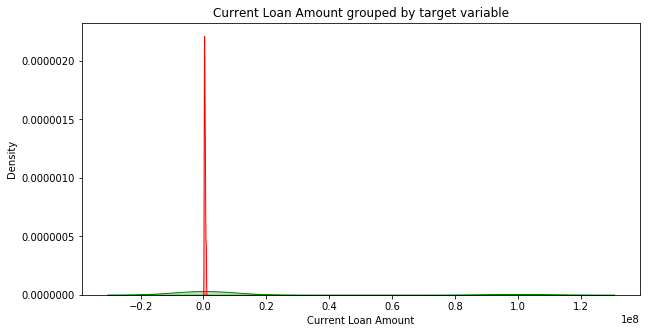

In [47]:
cla_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
cla_s = cla_with_target_s['Current Loan Amount']
cla_0 = cla_s[cla_with_target_s[TARGET_NAME] == 0]
cla_1 = cla_s[cla_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cla_0, shade=True, label='No default', color='g')
sns.kdeplot(cla_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

In [48]:
shapiro(cla_s)

ShapiroResult(statistic=0.39510518312454224, pvalue=0.0)

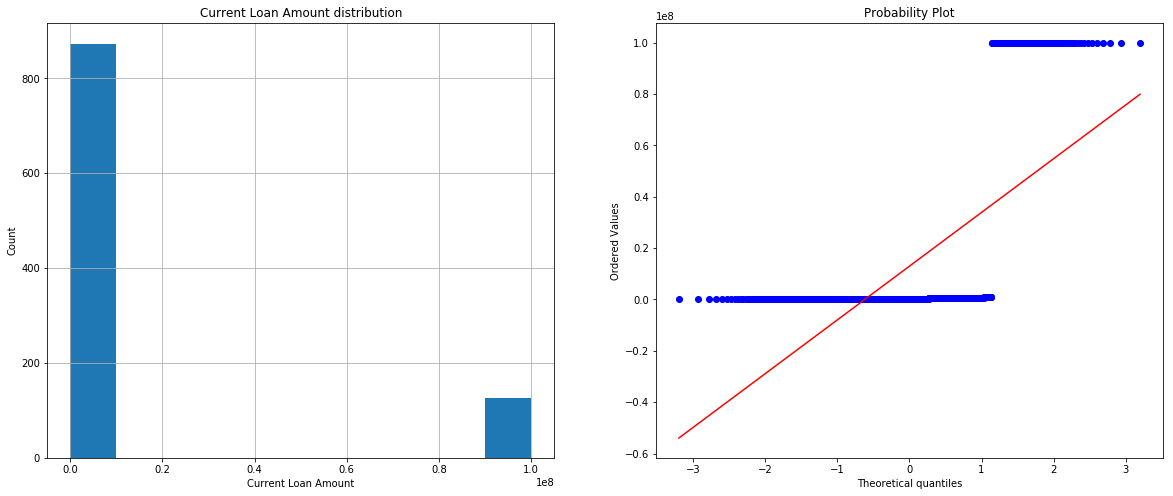

In [49]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
cla_s.hist()

plt.subplot(122)
probplot(cla_s, dist='norm', plot=plt)

plt.show()

In [50]:
mannwhitneyu(cla_0, cla_1)

MannwhitneyuResult(statistic=89129.5, pvalue=0.0013545164073726075)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

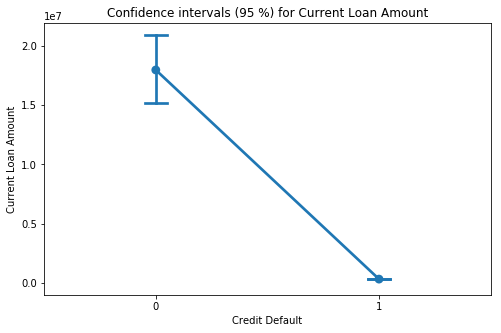

In [51]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=cla_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

### Вывод:
группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и признак 'Current Loan Amount' может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

#### Матрица корреляций

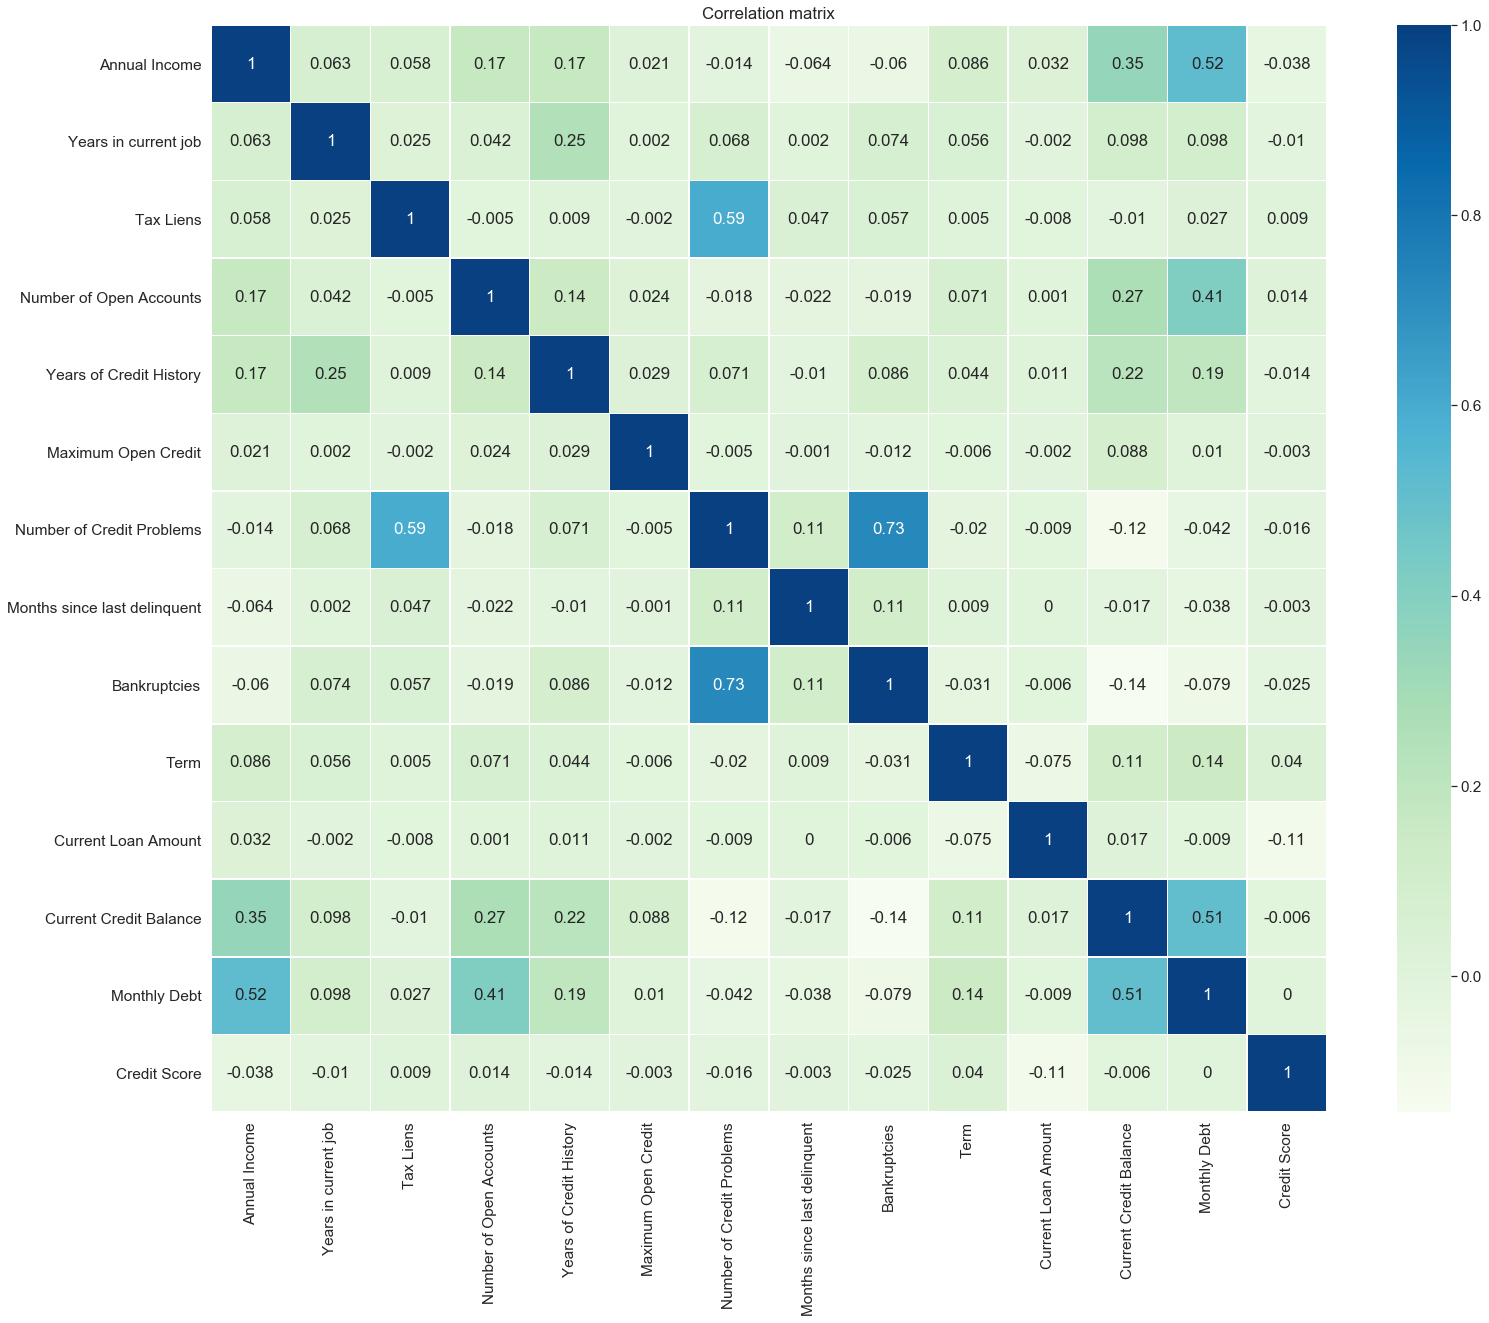

In [52]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Видно, что хорошо коррелируются между собой признаки Bankruptcies и Number of Credit Problems. 

### Нормализация данных

In [53]:
#df.drop([TARGET_NAME], axis=1, inplace=True)
df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding'],
      dtype='object')

In [54]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

df_norm = df.copy()


df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES]) # нормализуем числовые данные

df = df_norm.copy()
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-1.175263,1.075647,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-4.852876e-16,2.545372,-0.591517,...,0,0,0,0,0,0,0,0,0,0
1,-0.453071,1.075647,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-4.852876e-16,-0.337765,1.690569,...,0,0,0,0,0,0,0,0,0,0
2,-0.817324,0.526268,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-4.852876e-16,-0.337765,-0.591517,...,0,0,0,0,0,0,0,0,0,0
3,-0.746014,-0.023111,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-4.852876e-16,2.545372,-0.591517,...,0,0,0,0,0,0,0,0,0,0
4,-0.784295,0.526268,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-4.852876e-16,-0.337765,-0.591517,...,0,0,0,0,0,0,0,0,0,0


#### Разбиение на train и valid

In [55]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve

In [56]:
y = df[TARGET_NAME]
X = df[SELECTED_FEATURE_NAMES]          

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21, stratify = y)

In [57]:
df.shape

(7500, 34)

In [58]:
X_train.shape

(5250, 33)

In [59]:
y_train.shape

(5250,)

### Обработка выбросов в X_train

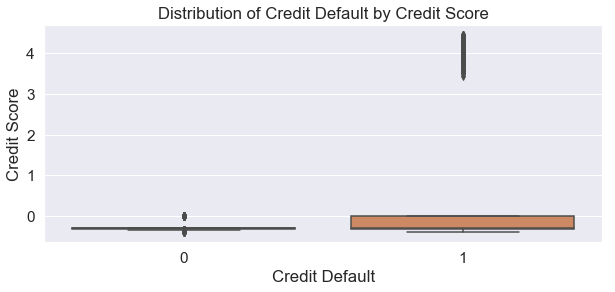

In [60]:
plt.figure(figsize=(10, 4))

sns.boxplot(y_train, X_train['Credit Score'], whis=1.5)

plt.xlabel('Credit Default')
plt.ylabel('Credit Score')
plt.title('Distribution of Credit Default by Credit Score')
plt.show()

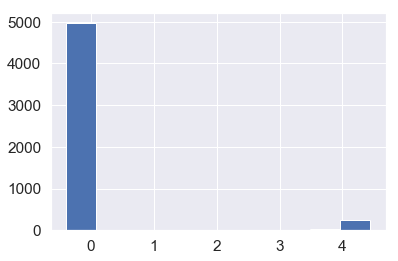

In [61]:
X_train['Credit Score'].hist()

In [62]:
X_train['Credit Score'].loc[X_train['Credit Score'] >3].count()

285

In [63]:
X_train['Credit Score'].quantile(.75)

0.0

In [64]:
X_train.shape

(5250, 33)

In [65]:
X_train['Credit Score'].shape

(5250,)

In [66]:
X_train['Credit Score'].quantile(.75)

0.0

In [67]:
X_train.loc[X_train['Credit Score'] >3, 'Credit Score'] = X_train['Credit Score'].quantile(.75)
                       


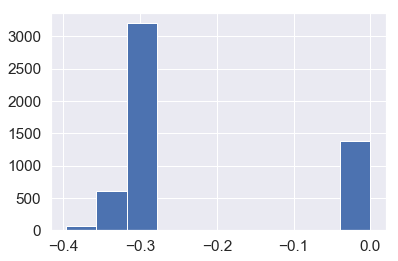

In [68]:
X_train['Credit Score'].hist()

### Балансировка целевой переменной

In [69]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name])- 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [70]:
target_name = TARGET_NAME

target_counts = df[target_name].value_counts()
target_counts

0    5387
1    2113
Name: Credit Default, dtype: int64

In [71]:
major_class_name = target_counts.argmax()
minor_class_name = target_counts.argmin()
major_class_name, minor_class_name

(0, 1)

In [72]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)


df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [73]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]


### Обучающий и валидационный датасет

In [74]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

### Построение и оценка базовой модели CatBoost

In [75]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

*CatBoost*

In [76]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

             precision    recall  f1-score   support

          0       0.89      0.95      0.92      3771
          1       0.93      0.85      0.89      2958

avg / total       0.91      0.90      0.90      6729

TEST

             precision    recall  f1-score   support

          0       0.80      0.84      0.82      1616
          1       0.53      0.47      0.50       634

avg / total       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1353  263
1                337  297


### Подбор гиперпараметров

In [77]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

In [78]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500, 2000],
          'max_depth':[3, 5, 7, 10]    
         }

In [79]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

In [ ]:
rs.best_params_

In [ ]:
rs.best_score_

Добавляем в модель CatBoost L2-регуляризацию, выбрав методом подбора l2_leaf_reg=800

In [ ]:
model_catb = catb.CatBoostClassifier(n_estimators=950, max_depth=3, l2_leaf_reg=800, silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

### Обработка тестовых данных

In [357]:
X_train.shape

(6729, 33)

In [358]:
y_train.shape

(6729,)

In [359]:
TEST_PATH = 'course_project/course_project_test.csv'

In [360]:
test = pd.read_csv(TEST_PATH)
test.shape

(2500, 16)

### Обработка пропусков, нулевых значений и значений некоторых категориальных признаков

In [361]:
test['Purpose'].unique()

array(['debt consolidation', 'educational expenses', 'home improvements',
       'major purchase', 'other', 'buy a car', 'medical bills',
       'buy house', 'business loan', 'take a trip', 'small business',
       'moving', 'vacation', 'wedding'], dtype=object)

In [362]:
test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [363]:
test.loc[test['Annual Income'].isnull(), 'Annual Income'] = test['Annual Income'].mean()

In [364]:
test['Months since last delinquent'].isna().value_counts()

True     1358
False    1142
Name: Months since last delinquent, dtype: int64

In [365]:
test.loc[test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = test['Months since last delinquent'].mean()

In [366]:
test['Credit Score'].isnull().value_counts()

False    1987
True      513
Name: Credit Score, dtype: int64

In [367]:
test.loc[test['Credit Score'].isnull(), 'Credit Score'] = test['Credit Score'].mean()

In [368]:
test['Years in current job'].isna().value_counts()

False    2414
True       86
Name: Years in current job, dtype: int64

In [369]:
test.loc[:,'Years in current job'].fillna(test['Years in current job'].mode()[0],inplace=True)

In [370]:
test['Years in current job'].isnull().value_counts()

False    2500
Name: Years in current job, dtype: int64

In [371]:
replace_nums = {"< 1 year": 0, "1 year": 1, "2 years": 2, "3 years": 3, "4 years": 4, "5 years": 5, "6 years":6,"7 years":7,"8 years":8, "9 years":9, "10+ years":10}
test['Years in current job'] = test['Years in current job'].replace(replace_nums)

In [372]:
test['Bankruptcies'].isnull().value_counts()

False    2497
True        3
Name: Bankruptcies, dtype: int64

In [373]:
test.loc[test['Bankruptcies'].isnull(), 'Bankruptcies'] = test['Bankruptcies'].mean()

In [374]:
test.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### Построение новых признаков

In [375]:
test['Term'].isna().value_counts()

False    2500
Name: Term, dtype: int64

In [376]:
test['Term'] = test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [377]:
df =  pd.get_dummies(test)
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1.366922e+06,4,0.0,9.0,12.5,220968.0,0.0,70.000000,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.318380e+05,1,0.0,6.0,32.7,55946.0,0.0,8.000000,0.0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.152540e+06,3,0.0,10.0,13.7,204600.0,0.0,34.181261,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.220313e+06,10,0.0,16.0,17.0,456302.0,0.0,70.000000,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.340952e+06,6,0.0,11.0,23.6,1207272.0,0.0,34.181261,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [378]:
df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_small business', 'Purpose_take a trip',
       'Purpose_vacation', 'Purpose_wedding'],
      dtype='object')

In [379]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()

In [380]:
NEW_FEATURE_NAMES = ['Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding']

  


In [381]:
NUM_FEATURE_NAMES = ['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',                   
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score'
 ]

In [382]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [383]:
df.shape

(2500, 32)

Поскольку в тестовом датасете отсутствует признак 'Purpose_renewable energy', для обеспечения размерности добавим на соответствующую позицию новый столбец, заполненный значениями Nan, которые заменим на 0.

In [384]:
df.insert(28, 'Purpose_renewable energy', np.nan, True)

In [385]:
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1.366922e+06,4,0.0,9.0,12.5,220968.0,0.0,70.000000,0.0,0,...,0,0,0,0,0,NaN,0,0,0,0
1,2.318380e+05,1,0.0,6.0,32.7,55946.0,0.0,8.000000,0.0,0,...,0,0,0,0,0,NaN,0,0,0,0
2,1.152540e+06,3,0.0,10.0,13.7,204600.0,0.0,34.181261,0.0,0,...,0,0,0,0,0,NaN,0,0,0,0
3,1.220313e+06,10,0.0,16.0,17.0,456302.0,0.0,70.000000,0.0,0,...,0,0,0,0,0,NaN,0,0,0,0
4,2.340952e+06,6,0.0,11.0,23.6,1207272.0,0.0,34.181261,0.0,1,...,0,0,0,0,0,NaN,0,0,0,0


In [386]:
df['Purpose_renewable energy'] = df['Purpose_renewable energy'].fillna(0)

In [387]:
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1.366922e+06,4,0.0,9.0,12.5,220968.0,0.0,70.000000,0.0,0,...,0,0,0,0,0,0.0,0,0,0,0
1,2.318380e+05,1,0.0,6.0,32.7,55946.0,0.0,8.000000,0.0,0,...,0,0,0,0,0,0.0,0,0,0,0
2,1.152540e+06,3,0.0,10.0,13.7,204600.0,0.0,34.181261,0.0,0,...,0,0,0,0,0,0.0,0,0,0,0
3,1.220313e+06,10,0.0,16.0,17.0,456302.0,0.0,70.000000,0.0,0,...,0,0,0,0,0,0.0,0,0,0,0
4,2.340952e+06,6,0.0,11.0,23.6,1207272.0,0.0,34.181261,0.0,1,...,0,0,0,0,0,0.0,0,0,0,0


In [388]:
df.shape

(2500, 33)

In [389]:
X_test = df

In [396]:
X_train.shape

(6729, 33)

#### Обучение и оценка финальной модели

In [397]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=3,l2_leaf_reg=800,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)
final_model.predict(X_test)


Wall time: 4.02 s


In [403]:
test_id = X_test.index
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Predictions"] = final_model.predict(X_test)

pred_df.to_csv('./predictions.csv', sep=',', index=None)

#### Сохранение модели в бинарном виде

In [399]:
import pickle

In [400]:
FINAL_MODEL_PATH = './final_model.pkl'

In [401]:
with open(FINAL_MODEL_PATH, 'wb') as file:
    pickle.dump(final_model, file)               